# US Foods COVID Analysis

Goal: 
1. Process US Foods data (source = https://usfoods.precima.io/)
2. Analyze data using COVID segmentation
3. Compare sell-out (US Foods) to sell-in (McCain) data

### 1. Load libraries, initiate folder/file paths
Run cell below

In [1]:
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
import teradatasql
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline

#path where dictionary file can be found
#Neil
DICTIONARY = r'C:\Users\NEWATTER\OneDrive - McCain Foods Limited\Distributor Sell-Out Dictionaries\\'
#Joe
#DICTIONARY = r'C:\Users\jcronk\McCain Foods Limited\GNA Data Strategy & Analytics - COVID Recovery\Distributor Sell-Out Dictionaries\\'

#main path
#Neil
PATH = r'C:\Users\NEWATTER\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\\'
#Joe
#PATH = r'C:\Users\jcronk\McCain Foods Limited\GNA Data Strategy & Analytics - COVID Recovery\Historical Sell-Out Sales\\'

#backup path
#Neil
BACKUP = r'C:\Users\NEWATTER\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\Backups\\'
#Joe
#BACKUP = r'C:\Users\jcronk\McCain Foods Limited\GNA Data Strategy & Analytics - COVID Recovery\Historical Sell-Out Sales\Backups\\'

#time dataframe
TIME = pd.read_excel(DICTIONARY + 'Time Definitions.xlsx')

### 2. Data Dictionary
Run cell below

In [2]:
def us_states():
    us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'American Samoa': 'AS',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Guam': 'GU',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Northern Mariana Islands':'MP',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Puerto Rico': 'PR',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virgin Islands': 'VI',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'
    }

    # thank you to @kinghelix and @trevormarburger for this idea
    abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))
    
    return pd.DataFrame.from_dict(abbrev_us_state, orient = 'index', columns = ['State Name']).rename_axis('State').reset_index()


def apply_dictionary(df, file_name):
    
    #create dictionary object from Excel file
    #adding sheet_name = None makes it a dictionary type
    _dict = pd.read_excel(DICTIONARY + file_name, sheet_name = None, engine='openpyxl')

    #create DataFrame from dictionary object called segments
    segments = pd.DataFrame.from_dict(_dict['Segment Mapping v2'])
    
    #create DataFrame from dictionary object called products
    products = pd.DataFrame.from_dict(_dict['SKU Mapping']).rename(columns={'McCain SKU ID':'SKU ID'})
    
    regions = pd.DataFrame.from_dict(_dict['Region Mapping'])
    
    #print shape of df (dimensions)
    print(f'Shape before adding dictionary: {df.shape}', flush = True)
    
    #testing total lbs to see if it matches after merge
    total_lbs = df['LBS'].sum()
    
    print(f'Total before dictionary: {total_lbs}', flush = True)
    
    #Category Segmentation
    #add lower case for merging
    segments['Pyramid Segment-lower'] = segments['Pyramid Segment'].str.lower()
    
    #create unique rows from dictionary
    segments = segments.groupby(['COVID Segmentation - L1','Pyramid Segment-lower',
                               'COVID Segmentation - L2','COVID Segmentation - (Restaurants)','COVID Segmentation - (Restaurants: Sub-Segment)',
                               'Restaurant Service Type'], dropna = False).size().reset_index().drop(columns={0})
    
    df = df.rename(columns = {'Pyr Segment':'Pyramid Segment',
                              'Division':'Market',
                              'MFG #':'Manufacturer Item Number',
                              'Product':'Product Description'})
    
    df = df.astype({'Manufacturer Item Number':'int64'}).astype({'Manufacturer Item Number':'str'})
    
    #add lower case key columns for merging (removes case mismatch)
    df['Pyramid Segment-lower'] = df['Pyramid Segment'].str.lower()
    df['PIM Group-lower'] = df['PIM Group'].str.lower()
    
    #remove lower case key columns
    df = df.merge(segments, how = 'left', left_on = ['Pyramid Segment-lower'], right_on = ['Pyramid Segment-lower']).drop(
        columns = {'Pyramid Segment-lower'})
    
    #Material Segementation
    #add lower case for merging
    #products['PIM Group-lower'] = products['PIM Group'].str.lower()
    
    products = products.groupby(['Manufacturer Item Number','SKU ID','Consolidated Category', 'L1 Product Hierarchy','L2 Product Hierarchy'], 
                                dropna = False).size().reset_index().drop(columns={0}).astype({'Manufacturer Item Number':'int64'}).astype({'Manufacturer Item Number':'str'})
    
    df = df.merge(products, how = 'left', on = 'Manufacturer Item Number')
    
    #Time segmentation
    df = df.merge(TIME[['Calendar Week Year']], how = 'left', 
                  left_on = ['Calendar Week'], right_on = ['Calendar Week Year'])
    
    df = df.merge(regions[['Market', 'State']], how = 'left', on = 'Market')
                  
    df = df.merge(us_states(), how = 'left', on = 'State')
    df.loc[df['State Name'].isna(), ['State', 'State Name']] = 'None'
    
    df['City'] = 'NA'
    
    #df = df[~df['Consolidated Category'].str.match('Other / Not Applicable')]
    
    #testing total lbs to see if it matches after merge
    total_lbs = df['LBS'].sum()
    print(f'Total after dictionary: {total_lbs}', flush = True)
    
    #print final shape to see if anything changes (would indicate duplicates in dictionary)
    print(f'Shape after adding dictionary: {df.shape}', flush = True)
    
    return df

### 3. Import File
Run cell below

In [3]:
def import_file(file_name):
    '''
    For importing base file
    '''
    _import = pd.read_csv(file_name)
    
    _import['Calendar Week'] = pd.to_numeric(_import['Calendar Week'], errors='coerce')
    
    return _import

def import_new_file(file_name):
    '''
    For importing new data
    '''
    
    if '.csv' in file_name:
        print(f'Importing csv file {dt.now()}', flush = True)
        
        df = pd.read_csv(file_name, low_memory = False, thousands = ',', dtype = {
            'MFG #':'str',
            'PIM #':'str',
            'ASYS #':'str',
            'Vendor #':'str'
        }).rename(columns = {'Year Week':'Calendar Week','LB Current':'LBS'})
        
    else:
        df = pd.read_excel(file_name)
        
        #drop blank column
        df.drop(df.columns[12], axis = 1, inplace = True)
        
        #create list of column names
        col_names = df.columns.tolist()
        
        #transform using first 13 columns (0:12) as row headers
        df = df.melt(id_vars=col_names[0:12], var_name="Calendar Week", value_name="LBS")
        
        #remove blank row
        df = df[df['Calendar Week'] != ' ']

        #convert calendar week to integer
        df['Calendar Week'] = df['Calendar Week'].astype('int64')
    
        df['LBS'] = df['LBS'].replace('-', np.nan)
        df['LBS'] = pd.to_numeric(df['LBS'])
    
    
    print(f'Import file shape: {df.shape}')
    
    return df

### 4. Calculation Functions
Run cell below

In [4]:
def add_rolling(df, _list):
    #groupby _list
    df = df.groupby(_list, dropna = False)[['LBS','LBS_LY','LBS_Baseline']].sum().reset_index()
    
    #set index to all but last column in list
    df = df.set_index(_list)
    
    #add new metric SMA_4 (simple moving average - 4 periods)
    #level = all but last 2 items in list
    df['LBS_Lag_1'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 1)
    df['LBS_Lag_2'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 2)
    df['LBS_Lag_3'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 3)
    df['LBS_Lag_4'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 4)
    
    df['SMA_4'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['SMA_4_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['SMA_4_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['LBS_Baseline_Lag_1'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].shift(periods = 1)
    df['LBS_LY_Lag_1'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 1)
    
    df['SMA_4_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4'].shift(periods = 1)
    df['SMA_4_LY_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4_LY'].shift(periods = 1)
    df['SMA_4_Baseline_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4_Baseline'].shift(periods = 1)
    
    return df.reset_index()


def add_last_year(df, _list):
    #list of groupby columns
    #last item in list is Calendar Week Year which is used to pull previous history (Baseline Week = Calendar Week Year) of copied dataframe
    _groupby = _list.copy()
    
    _merge_yoy = _list.copy()[0:-1]
    _merge_yoy.extend(['YOY Week'])
    
    _merge_baseline = _list.copy()[0:-1]
    _merge_baseline.extend(['Baseline Week'])
    
    df1 = df.groupby(_list, dropna = False)['LBS'].sum().reset_index()
    
    #groupby _list
    df_new = df.groupby(_list, dropna = False)['LBS'].sum().reset_index()
    
    #add week dimensions to main dataframe
    df_new = df_new.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')
    
    df_new = df_new.merge(df1, how='left', left_on=_merge_yoy, right_on=_groupby).drop(columns={'Calendar Week Year_y'}).rename(columns={'LBS_y':'LBS_LY'})
    
    df_new = df_new.merge(df1, how='left', left_on=_merge_baseline, right_on=_groupby).drop(columns={'Calendar Week Year'}).rename(columns={
        'LBS':'LBS_Baseline','Calendar Week Year_x':'Calendar Week Year','LBS_x':'LBS'})
    
    return df_new


def add_last_year_test(df, _list):
    control = df.groupby(_list)['LBS'].sum().to_dict()
    
    df = df.groupby(_list, dropna = False)['LBS'].sum().reset_index()
    
    #add week dimensions to main dataframe
    df = df.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')
    
    _merge_yoy = _list.copy()[0:-1]
    _merge_yoy.extend(['YOY Week'])
    
    _merge_baseline = _list.copy()[0:-1]
    _merge_baseline.extend(['Baseline Week'])
    
    df = df.set_index(_merge_yoy)
    df['LBS_LY'] = df.index.map(control)  
    df.reset_index()
    
    display(df.head())
    
    df = df.set_index(_merge_baseline)
    df['LBS_Baseline'] = df.index.map(control)
    
    return df.reset_index()

def add_precovid(df, _list, begin, end):
    #datefield should be last in _list
    datefield = _list[-1]
          
    #remove datefield from list
    _list = _list[0:-1]
    
    #filter data not using last and rename columns
    _df = df[(df[datefield] >= begin) & (df[datefield] <= end)].groupby(_list)['LBS'].sum() / 52
    
    return df.merge(
        _df, how = 'left', left_on = _list, right_on = _list).rename(
        columns = {'LBS_x':'LBS', 'LBS_y':'LBS_PRECOVID'}).fillna(
        value = {'LBS_PRECOVID': 0})


def add_time(df):
    df = df.merge(TIME[['Calendar Week Year','Week Starting (Sun)','Week Ending (Sat)', 'COVID Week']],
                   how = 'left', 
                   on = 'Calendar Week Year')
    
    df = df.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')
    
    return df


def analyze_1(df, _list, begin, end):
    if 'Calendar Week Year' not in _list:
        _list.extend(['Calendar Week Year'])
    
    df = full_dataframe(df, _list)
    
    #add last year lbs
    df = add_last_year(df, _list)
    
    #add rolling calculation
    df = add_rolling(df, _list)
        
    #add preCOVID baseline
    df = add_precovid(df, _list, begin, end)
    
    df = df.round({
        'LBS' : 2,    
        'SMA_4' : 2,
        'SMA_8' : 2,
        'SMA_12' : 2,
        'LBS_LY' : 2,    
        'SMA_4_LY' : 2,
        'SMA_8_LY' : 2,
        'SMA_12_LY' : 2,
        'LBS_Baseline' : 2,    
        'SMA_4_Baseline' : 2,
        'SMA_8_Baseline' : 2,
        'SMA_12_Baseline' : 2,
        'LBS_PRECOVID' : 2,
        'LBS_Lag_1' : 2,
        'LBS_Lag_2' : 2,
        'LBS_Lag_3' : 2,
        'LBS_Lag_4' : 2,
        'LBS_Baseline_Lag_1': 2,
        'LBS_LY_Lag_1': 2,
        'SMA_4_Lag_1' : 2,
        'SMA_4_LY_Lag_1' : 2,
        'SMA_4_Baseline_Lag_1' : 2
        
    }).fillna(value = {
        'LBS' : 0,    
        'SMA_4' : 0,
        'SMA_8' : 0,
        'SMA_12' : 0,
        'LBS_LY' : 0,    
        'SMA_4_LY' : 0,
        'SMA_8_LY' : 0,
        'SMA_12_LY' : 0,
        'LBS_Baseline' : 0,    
        'SMA_4_Baseline' : 0,
        'SMA_8_Baseline' : 0,
        'SMA_12_Baseline' : 0,
        'LBS_PRECOVID' : 0,
        'LBS_Lag_1' : 0,
        'LBS_Lag_2' : 0,
        'LBS_Lag_3' : 0,
        'LBS_Lag_4' : 0,
        'LBS_Baseline_Lag_1': 2,
        'LBS_LY_Lag_1': 2,
        'SMA_4_Lag_1' : 0,
        'SMA_4_LY_Lag_1' : 0,
        'SMA_4_Baseline_Lag_1' : 0
    })
    
    return df


def save_backup(df, file_name):
    
    df.to_csv(BACKUP + file_name)
    
    return


def td_to_pandas(query, cur, title=''):
    _data = []
    _start=dt.now()
    print(dt.now().strftime('%m/%d/%Y'))
    print(f'{title} Execution started...', end='', flush=True)
    cur.execute (query)
    print(f'finished. {dt.now() - _start}', flush=True) 
    _start_fetch=dt.now()
    print(f'{title} Fetching data started...', end='', flush=True)
    for row in cur.fetchall():
        _data.append(row) 
    print(f'finished. {dt.now() - _start_fetch}', flush=True) 
    _start=dt.now()
    print(f'{title} Creating DataFrame for started...', end='', flush=True)
    _df = pd.DataFrame(_data)
    _df.columns = [x[0].replace('SAP_', '').lower() for x in cur.description]
    print(f'finished. {dt.now() - _start}', flush=True)
    return _df


def td_dataframe(select_db, query):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            print('Database selected!', flush=True)            
            dim_df = td_to_pandas(query, cur, 'Query:')
            print('Dim:', dim_df.shape)
    
    return dim_df


def restaurants(df):
    #restaurants = df.loc[df['COVID Segmentation - (Restaurants)'] == 'Restaurants', :]
    
    if df.columns.isin(['COVID Segmentation - L2']).sum() > 0:
        #Rename rows
        df.loc[df['COVID Segmentation - L2'] == 'Independents (IOs) / Local Eateries / Takeaway', 'COVID Segmentation - L2'] = 'IO'
        df.loc[
            (df['COVID Segmentation - L2'] == 'All Other') | 
            (df['COVID Segmentation - L2'] == 'National Account') | 
            (df['COVID Segmentation - L2'] == 'Region Chains')| 
            (df['COVID Segmentation - L2'] == 'National Accounts'),
            'COVID Segmentation - L2'] = 'Chain'
    
    return df

def process_list(df, work_list):
    
    _process = analyze_1(df, work_list, 201910, 202009)
    
    _process = restaurants(_process)
    
    _process['Distributor'] = 'US Foods'
    
    _process = add_time(_process)
    
    #for standardizing output
    work_list.extend(['Distributor','LBS','SMA_4','SMA_8','SMA_12',
                      'YOY Week','LBS_LY','SMA_4_LY','SMA_8_LY','SMA_12_LY',
                      'Baseline Week','LBS_Baseline','SMA_4_Baseline','SMA_8_Baseline','SMA_12_Baseline',
                      'LBS_Lag_1','LBS_Lag_2','LBS_Lag_3','LBS_Lag_4','LBS_Baseline_Lag_1','LBS_LY_Lag_1',
                      'SMA_4_Lag_1', 'SMA_4_LY_Lag_1', 'SMA_4_Baseline_Lag_1',
                      'LBS_PRECOVID','Week Starting (Sun)','Week Ending (Sat)','COVID Week'])
    
    if 'SKU ID' in work_list:
        #last 26 weeks in dataframe
        week_list = _process.groupby(['Calendar Week Year']).size().reset_index().drop(columns={0}).sort_values(by = 'Calendar Week Year', ascending = True).squeeze().tolist()[-26:]
        
        #filter to only the last 26 weeks
        _process = _process[_process['Calendar Week Year'].isin(week_list)]
    
    return _process[work_list]

def is_missing(df):
    #check for COVID Segmentation - L1
    missing = df[df['COVID Segmentation - L1'].isna()].groupby(['Pyramid Segment'], as_index = False, dropna = False)['LBS'].sum()

    if len(missing) > 0:
        print('The following segments are missing:')
        display(missing)
        missing.to_excel(DICTIONARY + 'Segments Missing Dump\\' + dt.now().strftime('%Y%m%d') + '_us_foods_L1_missing.xlsx', index = False)
    else:
        print(f'Nothing missing for COVID Segmentation - L1', flush = True)

    #check for product
    missing = df[df['Consolidated Category'].isna()].groupby(['Merch Category','PIM Group','Manufacturer Item Number',
                                                              'Product Description','Pack Size'], as_index = False, dropna = False)['LBS'].sum()

    if len(missing) > 0:
        print('The following products are missing:')
        display(missing)
        missing.to_excel(DICTIONARY + 'Segments Missing Dump\\' + dt.now().strftime('%Y%m%d') + r'_us_foods_sku_missing.xlsx', index = False)
    else:
        print(f'Nothing missing for Product', flush = True)
        

def full_dataframe(df, _list):
    print(_list)
    
    weeks = df.groupby(['Calendar Week Year']).size().reset_index().drop(columns={0})
    segments = df.groupby(_list[0:-1]).size().reset_index().drop(columns={0})
    
    _df = segments.assign(key=1).merge(weeks.assign(key=1), how='outer', on='key').drop(columns = {'key'}) 
    
    return _df.merge(df, how = 'left', on = _list) 

def clean_city(df):
    df['City'] = df['City'].str.strip()
    df['City'] = df['City'].str.upper()
    df['City'].fillna('NA', inplace = True)
    
    #cities = 'TORONTO|MONTREAL|OTTAWA|CALGARY|VANCOUVER|WINNIPEG|MONTREAL|HAMILTON|HALIFAX'
    cities = 'NOT USED CURRENTLY'
    
    #change each city name to the name of the city that matches, cleans up the city names
    for c in cities.split('|'):
        df.loc[df['City'].str.match(c), 'City'] = c
    
    #change all other cities to NA
    df.loc[~df['City'].str.match(cities), 'City'] = 'NA'
    
    return df

### 5. Sell-in vs. Sell-out
Run cell below

In [5]:
def teradata_sales(sellout):
    #SET QUERY_BAND = 'ApplicationName=MicroStrategy;Version=9.0;ClientUser=NEWATTER;Source=Vantage; Action=BEK Performance;StartTime=20200901T101924;JobID=55096;Importance=666;'  FOR SESSION;
    
    #the current week is pulled from the time dictionary table
    to_week = int(TIME[(TIME['Week Starting (Mon)'] <= dt.now()) & (TIME['Week Ending (Sun)'] >= dt.now())]['Calendar Week Year'].values)
    
    print(f'Starting Teradata connect...', flush = True)
    
    select_db = "DATABASE DL_GBL_TAS_BI"

    query = '''
    select a14.FISCAL_WEEK_NUMBER as FISCAL_WEEK_NUMBER,
    (a14.FISCAL_WEEK_NUMBER_DESCR || ' ' || a14.START_DATE_OF_SAPYW) as FISCAL_WEEK,
    a14.CALENDAR_WEEK_NAME as CALENDAR_WEEK_NUMBER,
    (a14.CALENDAR_WEEK_LONG_DESCRIPTION || ' ' || a14.START_DATE_OF_SAPYW) as CALENDAR_WEEK,
    RIGHT(a16.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)) as CUSTOMER_HIER_LVL_1,
    a16.CUSTOMER_HIER_LVL_1_NAME as CUSTOMER_HIER_LVL_1_NAME,
    a13.DIVISION_ID as DIVISION,
    a17.DIVISION_NAME as DIVISION_NAME,
    a12.CATEGORY_SHORT_CODE as CATEGORY_SHORT_CODE,
    a12.CATEGORY_DESC as CATEGORY_DESC,
    a15.MATERIAL_PRICING_GROUP_ID as MATERIAL_PRICING_GROUP_ID,
    a18.MATERIAL_PRICING_GROUP_DESCRIPTION as MATERIAL_PRICING_GROUP_DESCRIPTION,
    TRIM (LEADING '0' FROM a13.MATERIAL_ID) as MATERIAL_ID,
    a13.MATERIAL_DESCRIPTION as MATERIAL_NAME,
    sum(a11.SALES_VOLUME_WEIGHT_LBS) as ACTUAL_VOLUME_LBS
    from DL_GBL_TAS_BI.FACT_SALES_ACTUAL as a11
    join DL_GBL_TAS_BI.VW_H_PRODUCT_ALL_SALES as a12
    on (a11.MATERIAL_ID = a12.MATERIAL_ID)
    join DL_GBL_TAS_BI.D_MATERIAL_DN_ALL as a13
    on (a11.MATERIAL_ID = a13.MATERIAL_ID)
    join DL_GBL_TAS_BI.D_TIME_FY_V6 as a14
    on (a11.ACCOUNTING_PERIOD_DATE = a14.DAY_CALENDAR_DATE)
    join DL_GBL_TAS_BI.D_MATERIAL_SALES_DATA as a15
    on (a11.DISTRIBUTION_CHANNEL_ID = a15.DISTRIBUTION_CHANNEL_ID and 
    a11.MATERIAL_ID = a15.MATERIAL_ID and 
    a11.SALES_ORGANISATION_ID = a15.SALES_ORGANISATION_ID)
    join DL_GBL_TAS_BI.VW_H_CUSTOMER_ALL_DIVISION00 as a16
    on (a11.CUSTOMER_ID = a16.CUSTOMER and 
    a11.DISTRIBUTION_CHANNEL_ID = a16.DISTRIBUTION_CHANNEL and 
    a11.SALES_ORGANISATION_ID = a16.SALES_ORGANISATION)
    join DL_GBL_TAS_BI.D_DIVISION as a17
    on (a13.DIVISION_ID = a17.DIVISION_ID)
    join DL_GBL_TAS_BI.D_MATERIAL_PRICING_GROUP as a18
    on (a15.MATERIAL_PRICING_GROUP_ID = a18.MATERIAL_PRICING_GROUP_ID)
    where (a14.FISCAL_YEAR_CODE in ('FY2019', 'FY2020', 'FY2021','FY2022')
    and a11.SALES_ORGANISATION_ID in ('US01')
    and a11.DISTRIBUTION_CHANNEL_ID in ('10')
    and RIGHT(a16.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)) in ('6500002818'))
    and A14.CALENDAR_WEEK_NAME < ''' + str(to_week) + ''' 
    group by a14.FISCAL_WEEK_NUMBER,
    (a14.FISCAL_WEEK_NUMBER_DESCR || ' ' || a14.START_DATE_OF_SAPYW),
    RIGHT(a16.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)),
    a14.CALENDAR_WEEK_NAME,
    (a14.CALENDAR_WEEK_LONG_DESCRIPTION || ' ' || a14.START_DATE_OF_SAPYW),
    a16.CUSTOMER_HIER_LVL_1_NAME,
    a13.DIVISION_ID,
    a17.DIVISION_NAME,
    a12.CATEGORY_SHORT_CODE,
    a12.CATEGORY_DESC,
    a15.MATERIAL_PRICING_GROUP_ID,
    a18.MATERIAL_PRICING_GROUP_DESCRIPTION,
    TRIM (LEADING '0' FROM a13.MATERIAL_ID),
    a13.MATERIAL_DESCRIPTION
    order by FISCAL_WEEK_NUMBER asc
;'''

    #create dataframe using both functions td_to_pandas and td_dataframe
    df = td_dataframe(select_db, query)
    
    return teradata_transform(df, sellout)


def teradata_transform(sellin, sellout):
    #consolidates teradata sales with sellout data
    
    #convert from object datatype to float (exports as a number instead of string)
    sellin['actual_volume_lbs'] = sellin['actual_volume_lbs'].astype('float64')
    
    #rename columns for consistancy
    sellin = sellin.rename(columns = {'actual_volume_lbs':'LBS', 'calendar_week_number':'Calendar Week Year'})
    
    #transform calendar week year from teradata
    sellin['Calendar Week Year'] = pd.to_numeric(sellin['Calendar Week Year'], errors = 'coerce')

    #transform category so its consolidated
    sellin['Consolidated Category'] = sellin['category_desc']
    sellin.loc[sellin['Consolidated Category'] == 'Sweet Potato' , 'Consolidated Category'] = 'Potato'
    sellin.loc[sellin['Consolidated Category'] != 'Potato' , 'Consolidated Category'] = 'Prepared Foods'
    
    #analyze sellin data
    sellin = analyze_1(sellin, ['Consolidated Category'], 201910, 202009)
    
    #rename columns accordingly
    sellin = sellin.rename(columns = {'LBS':'MCCAIN LBS',
                                      'SMA_4':'MCCAIN SMA_4',
                                      'SMA_8':'MCCAIN SMA_8',
                                      'SMA_12':'MCCAIN SMA_12',
                                      'LBS_PRECOVID':'MCCAIN PRECOVID',
                                      'LBS_Lag_1':'MCCAIN Lag_1',
                                      'LBS_Lag_2':'MCCAIN Lag_2',
                                      'LBS_Lag_3':'MCCAIN Lag_3',
                                      'LBS_Lag_4':'MCCAIN Lag_4',
                                      'LBS_Baseline' : 'MCCAIN LBS_Baseline',
                                      'SMA_4_Baseline' : 'MCCAIN SMA_4_Baseline',
                                      'SMA_8_Baseline' : 'MCCAIN SMA_8_Baseline',
                                      'SMA_12_Baseline' : 'MCCAIN SMA_12_Baseline',
                                      'SMA_4_Lag_1':'MCCAIN SMA_4_Lag_1',
                                      'SMA_4_Baseline_Lag_1' : 'MCCAIN SMA_4_Baseline_Lag_1',
                                      'LBS_Baseline_Lag_1': 'MCCAIN LBS_Baseline_Lag_1'
                                     })
    
    #analyze sellout data
    df = analyze_1(sellout, ['Consolidated Category'], 201910, 202009)
    
    
    df = df.merge(sellin[['Calendar Week Year','Consolidated Category','MCCAIN LBS','MCCAIN SMA_4','MCCAIN SMA_8','MCCAIN SMA_12','MCCAIN PRECOVID',
                          'MCCAIN LBS_Baseline','MCCAIN SMA_4_Baseline','MCCAIN SMA_8_Baseline','MCCAIN SMA_12_Baseline',
                          'MCCAIN Lag_1', 'MCCAIN Lag_2', 'MCCAIN Lag_3', 'MCCAIN Lag_4','MCCAIN LBS_Baseline_Lag_1',
                          'MCCAIN SMA_4_Lag_1', 'MCCAIN SMA_4_Baseline_Lag_1']], how = 'left', 
                  left_on = ['Calendar Week Year','Consolidated Category'], right_on = ['Calendar Week Year','Consolidated Category'])
    
    df = df.fillna({'MCCAIN LBS': 0,
                    'MCCAIN SMA_4': 0,
                    'MCCAIN SMA_8': 0,
                    'MCCAIN SMA_12': 0,
                    'MCCAIN PRECOVID': 0,
                    'MCCAIN Lag_1': 0,
                    'MCCAIN Lag_2': 0,
                    'MCCAIN Lag_3': 0,
                    'MCCAIN Lag_4': 0,
                    'MCCAIN LBS_Baseline': 0,
                    'MCCAIN SMA_4_Baseline': 0,
                    'MCCAIN SMA_8_Baseline': 0,
                    'MCCAIN SMA_12_Baseline': 0,
                    'MCCAIN LBS_Baseline_Lag_1':0,
                    'MCCAIN SMA_4_Lag_1' : 0,
                    'MCCAIN SMA_4_Baseline_Lag_1' : 0
                   })
    
    df['Distributor'] = 'US Foods'

    df = add_time(df)
    
    df = df[['Consolidated Category','Distributor','Calendar Week Year',
             'LBS','SMA_4','SMA_8','SMA_12','LBS_PRECOVID',
             'LBS_Baseline','SMA_4_Baseline','SMA_8_Baseline','SMA_12_Baseline',
             'LBS_Lag_1', 'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4', 'LBS_Baseline_Lag_1', 'SMA_4_Lag_1', 'SMA_4_Baseline_Lag_1',
             'MCCAIN LBS','MCCAIN SMA_4','MCCAIN SMA_8','MCCAIN SMA_12','MCCAIN PRECOVID',
             'MCCAIN LBS_Baseline','MCCAIN SMA_4_Baseline','MCCAIN SMA_8_Baseline','MCCAIN SMA_12_Baseline',
             'MCCAIN Lag_1', 'MCCAIN Lag_2', 'MCCAIN Lag_3', 'MCCAIN Lag_4','MCCAIN LBS_Baseline_Lag_1','MCCAIN SMA_4_Lag_1','MCCAIN SMA_4_Baseline_Lag_1',
             'Week Starting (Sun)','Week Ending (Sat)','COVID Week']]
    
    return df

### 6. Import Raw Data
Run cell below

In [6]:
'''
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60915 entries, 0 to 60914
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               60915 non-null  object 
 1   Area                 60915 non-null  object 
 2   Market               60915 non-null  object 
 3   Pyramid Segment      60915 non-null  object 
 4   Business Unit        60915 non-null  object 
 5   Merch Category       60915 non-null  object 
 6   PIM Group            60915 non-null  object 
 7   MFG #                60915 non-null  object 
 8   PIM #                60915 non-null  object 
 9   ASYS #               60915 non-null  object 
 10  Product Description  60915 non-null  object 
 11  Pack Size            60915 non-null  object 
 12  Vendor #             60915 non-null  object 
 13  Vendor               60915 non-null  object 
 14  Brand                60915 non-null  object 
 15  Brand Type           60915 non-null  object 
 16  Attribute 1          60915 non-null  object 
 17  Attribute 2          60915 non-null  object 
 18  Attribute 3          60915 non-null  object 
 19  Attribute 4          60915 non-null  object 
 20  Attribute 5          60915 non-null  object 
 21  Calendar Week        60915 non-null  int64  
 22  LBS                  60915 non-null  float64
dtypes: float64(1), int64(1), object(21)
memory usage: 10.7+ MB
'''

#new file name in historical file directory
_new = import_new_file(PATH + 'US Foods Update.csv')

print(f'Imported {_new.shape[0]} records', flush = True)

Importing csv file 2022-07-07 15:33:05.760387
Import file shape: (69198, 23)
Imported 69198 records


### 7. Apply Dictionary to Raw Data / Check For Missing Segmentation
Run cell below

In [7]:
#add dictionary to new data
_new_df = apply_dictionary(_new, 'US Foods - US.xlsx')

#look for missing segmentation
is_missing(_new_df)

Shape before adding dictionary: (69198, 23)
Total before dictionary: 47958346.21
Total after dictionary: 47958346.21
Shape after adding dictionary: (69198, 37)
Nothing missing for COVID Segmentation - L1
Nothing missing for Product


### 8. Combine New and Base Datasets
Run cell below

In [8]:
_import_df = pd.read_csv(BACKUP + 'US FOODS.csv')

print(f'Imported shape...{_import_df.shape}', flush = True)

#create unique list values
exclude_list = list(dict.fromkeys(_new_df['Calendar Week Year'].values.squeeze().tolist()))

#turn list to string
include = str(exclude_list)[1:-1]

#to include city even though it's not in dataset
_import_df['City'] = 'NA'

#import all records from base data minus the new data
_base = _import_df[~_import_df['Calendar Week Year'].isin(exclude_list)][['City', 'State', 'State Name', 'Pyramid Segment','COVID Segmentation - L1','COVID Segmentation - L2','COVID Segmentation - (Restaurants)',
              'COVID Segmentation - (Restaurants: Sub-Segment)','Restaurant Service Type','Consolidated Category',
              'SKU ID','L1 Product Hierarchy','L2 Product Hierarchy','Calendar Week Year','LBS']].append(
        _new_df[['City', 'State', 'State Name', 'Pyramid Segment','COVID Segmentation - L1','COVID Segmentation - L2','COVID Segmentation - (Restaurants)',
              'COVID Segmentation - (Restaurants: Sub-Segment)','Restaurant Service Type','Consolidated Category',
              'SKU ID','L1 Product Hierarchy','L2 Product Hierarchy','Calendar Week Year','LBS']]
)

#clean city names
_base = clean_city(_base)

_base = _base[~_base['Consolidated Category'].str.match('Other')]

print(f'Final shape...{_base.shape}', flush = True)


Imported shape...(1506308, 16)


C:\Users\newatter\AppData\Local\Temp\1\ipykernel_23800\344331197.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _base = _import_df[~_import_df['Calendar Week Year'].isin(exclude_list)][['City', 'State', 'State Name', 'Pyramid Segment','COVID Segmentation - L1','COVID Segmentation - L2','COVID Segmentation - (Restaurants)',


Final shape...(1528778, 15)


### 9. Execute Analysis
Run cell below

In [9]:

_list = []

#Output 1: COVID L1 - List 0
_list.append(['City', 'State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

#Output 2: COVID L1 - List 1
_list.append(['State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','SKU ID','Consolidated Category','L1 Product Hierarchy','L2 Product Hierarchy'])

#Output 4: Pyramid Segment - List 2
_list.append(['Pyramid Segment','Consolidated Category'])

print(f'Processing Region', flush = True)
output1 = process_list(_base, _list[0])

#print(f'Processing Region SKU', flush = True)
#output2 = process_list(_base, _list[1])

print(f'Processing Pyramid', flush = True)
output4 = process_list(_base, _list[2])

print(f'Processing Sell in vs Sell out', flush = True)
output3 = teradata_sales(_base)

print('All done')

Processing Region
['City', 'State Name', 'COVID Segmentation - L1', 'COVID Segmentation - L2', 'Restaurant Service Type', 'Consolidated Category', 'Calendar Week Year']
Processing Pyramid
['Pyramid Segment', 'Consolidated Category', 'Calendar Week Year']
Processing Sell in vs Sell out
Starting Teradata connect...
Database selected!
07/07/2022
Query: Execution started...finished. 0:00:55.852496
Query: Fetching data started...finished. 0:00:16.106356
Query: Creating DataFrame for started...finished. 0:00:00.085558
Dim: (49491, 15)
['Consolidated Category', 'Calendar Week Year']
['Consolidated Category', 'Calendar Week Year']
All done


### 10. Upload Analysis to Teradata
Run cell below

In [10]:
def td_upload(select_db, df, table_name):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            d = dt.now().strftime('%m/%d/%Y %H:%M:%S %p')
            print(f'Database selected! {d}', flush=True)           

            delete_from_td(df, table_name, cur)
            insert_into_td(df, table_name, cur)
            
def delete_from_td(df, table_name, cur):
    distributor = df.groupby('Distributor').size().reset_index().drop(columns=0).to_numpy()[0][0]
    
    print(f'Deleting records for: {distributor} in table: {table_name}', flush = True)          
    print(f'Deleting weeks: {include}', flush = True)
    
    query = '''
    DELETE FROM ''' + table_name  + ''' 
    WHERE "Distributor" = ''' + "'" + distributor + "'" + ''' AND "Calendar Week Year" IN (''' + include + ")"
    
    #query = '''
    #DELETE FROM ''' + table_name  + ''' 
    #WHERE "Distributor" = ''' + "'" + distributor + "'"
    
    cur.execute (query)
    
def insert_into_td(df, table_name, cur):
    insert_list = df.values.tolist()
    
    #creates ?, ?,.... string used in query for teradata fastload
    insert_columns = ('?, ' * len(df.columns)).rstrip(', ')
    
    print(f'Inserting records into {table_name}', flush = True)
    
    query = "INSERT INTO " + table_name  + " (" + insert_columns + ")"
    #query = "{fn teradata_try_fastload}INSERT INTO " + table_name  + " (" + insert_columns + ")"
    
    cur.execute (query, insert_list)
    
    print(f'Inserted {df.shape[0]} records', flush = True)
    

select_db = 'DATABASE DL_NA_PROTOTYPING'

td_upload(select_db, output1[output1['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_REGION')
td_upload(select_db, output4[output4['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_SPECIAL_1')
td_upload(select_db, output3[output3['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_AND_SELLIN')

#td_upload(select_db, output2[output2['Calendar Week Year'].isin(exclude_list)].astype({'SKU ID':'str'}), 'SELLOUT_REGION_SKU')
#td_upload(select_db, output2[(output2['Calendar Week Year'] >= 201901) & (output2['Calendar Week Year'] < 202001)].astype({'SKU ID':'str'}), 'SELLOUT_REGION_SKU')

#td_upload(select_db, output1, 'SELLOUT_REGION')
#td_upload(select_db, output4, 'SELLOUT_SPECIAL_1')
#td_upload(select_db, output3, 'SELLOUT_AND_SELLIN')

print('All done', flush = True)

Database selected! 07/07/2022 15:34:50 PM
Deleting records for: US Foods in table: SELLOUT_REGION
Deleting weeks: 202218, 202214, 202215, 202224, 202216, 202217, 202219, 202220, 202221, 202225, 202226, 202222, 202223
Inserting records into SELLOUT_REGION
Inserted 7670 records
Database selected! 07/07/2022 15:34:57 PM
Deleting records for: US Foods in table: SELLOUT_SPECIAL_1
Deleting weeks: 202218, 202214, 202215, 202224, 202216, 202217, 202219, 202220, 202221, 202225, 202226, 202222, 202223
Inserting records into SELLOUT_SPECIAL_1
Inserted 247 records
Database selected! 07/07/2022 15:34:59 PM
Deleting records for: US Foods in table: SELLOUT_AND_SELLIN
Deleting weeks: 202218, 202214, 202215, 202224, 202216, 202217, 202219, 202220, 202221, 202225, 202226, 202222, 202223
Inserting records into SELLOUT_AND_SELLIN
Inserted 39 records
All done


In [24]:
output1.columns

Index(['City', 'State Name', 'COVID Segmentation - L1',
       'COVID Segmentation - L2', 'Restaurant Service Type',
       'Consolidated Category', 'Calendar Week Year', 'Distributor', 'LBS',
       'SMA_4', 'SMA_8', 'SMA_12', 'YOY Week', 'LBS_LY', 'SMA_4_LY',
       'SMA_8_LY', 'SMA_12_LY', 'Baseline Week', 'LBS_Baseline',
       'SMA_4_Baseline', 'SMA_8_Baseline', 'SMA_12_Baseline', 'LBS_Lag_1',
       'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4', 'LBS_Lag_4',
       'LBS_Baseline_Lag_1', 'LBS_LY_Lag_1', 'SMA_4_Lag_1', 'SMA_4_LY_Lag_1',
       'SMA_4_Baseline_Lag_1', 'LBS_PRECOVID', 'Week Starting (Sun)',
       'Week Ending (Sat)', 'COVID Week'],
      dtype='object')

### Save Backup When Ready

In [11]:
save_backup(_base, 'US FOODS.csv')

### Testing

In [164]:
_list = []

#Output 1: COVID L1 - List 0
_list.append(['City', 'State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

print(f'Processing Region', flush = True)
output1 = process_list(_base, _list[0])

output1.head()

Processing Region
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78574 entries, 0 to 78573
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     78574 non-null  object        
 1   State Name               78574 non-null  object        
 2   COVID Segmentation - L1  78574 non-null  object        
 3   COVID Segmentation - L2  78574 non-null  object        
 4   Restaurant Service Type  78574 non-null  object        
 5   Consolidated Category    78574 non-null  object        
 6   Calendar Week Year       78574 non-null  int64         
 7   LBS                      78574 non-null  float64       
 8   LBS_LY                   78574 non-null  float64       
 9   LBS_Baseline             78574 non-null  float64       
 10  LBS_Lag_1                78574 non-null  float64       
 11  LBS_Lag_2                78574 non-null  float64       
 12  LBS_Lag_3     

None

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,Calendar Week Year,Distributor,LBS,SMA_4,...,SMA_8_Baseline,SMA_12_Baseline,LBS_Lag_1,LBS_Lag_2,LBS_Lag_3,LBS_Lag_4,LBS_PRECOVID,Week Starting (Sun),Week Ending (Sat),COVID Week
0,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201901,US Foods,1694.6,1694.60,...,1694.60,1694.60,0.0,0.0,0.0,0.0,5027.19,2018-12-30,2019-01-05,0
1,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201902,US Foods,2324.1,2009.35,...,2009.35,2009.35,1694.6,0.0,0.0,0.0,5027.19,2019-01-06,2019-01-12,0
2,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201903,US Foods,3357.0,2458.57,...,2458.57,2458.57,2324.1,1694.6,0.0,0.0,5027.19,2019-01-13,2019-01-19,0
3,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201904,US Foods,9396.0,4192.92,...,4192.92,4192.92,3357.0,2324.1,1694.6,0.0,5027.19,2019-01-20,2019-01-26,0
4,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201905,US Foods,1737.0,4203.52,...,3701.74,3701.74,9396.0,3357.0,2324.1,1694.6,5027.19,2019-01-27,2019-02-02,0


In [59]:
test1 = _base[['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 'Consolidated Category', 'Calendar Week Year','LBS']].copy()

test1_group = test1.groupby(['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 'Consolidated Category', 'Calendar Week Year'])['LBS'].sum()

test1_group

City  State Name  COVID Segmentation - L1   COVID Segmentation - L2  Restaurant Service Type  Consolidated Category  Calendar Week Year
NA    Alabama     All Other Non-Commercial  Not Applicable           Non-Restaurants          Potato                 201901                1694.6
                                                                                                                     201902                2324.1
                                                                                                                     201903                3357.0
                                                                                                                     201904                9396.0
                                                                                                                     201905                1737.0
                                                                                                                                      

In [94]:
test2 = _base[['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 
               'Consolidated Category', 'Calendar Week Year','LBS']].copy()

test2 = test2.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')

test2

#test2_group = test2.groupby(['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 'Consolidated Category', 'YOY Week'])['LBS'].sum()

#test2_group

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,Calendar Week Year,LBS,YOY Week,Baseline Week
0,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Potato,201903,24.0,201803,201903
1,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,201903,15.0,201803,201903
2,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Potato,201903,96.0,201803,201903
3,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,201903,48.0,201803,201903
4,NA,North Dakota,Public Sector (On site),Not Applicable,Non-Restaurants,Potato,201903,150.0,201803,201903
...,...,...,...,...,...,...,...,...,...,...
1404265,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202148,11052.0,202049,201949
1404266,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202149,10008.0,202050,201950
1404267,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202150,9504.0,202051,201951
1404268,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202151,10512.0,202052,201952


In [111]:
def pull_yoy(row):
    print(row)
    #print(np.take(test2_group, row['Calendar Week Year']))
          
    return
          
test3 = test2_group.copy()

test3.apply(lambda x: pull_yoy(x.index))



AttributeError: 'float' object has no attribute 'index'

In [74]:
test1.index[0][-1]

201901

In [35]:
test3 = pd.concat([test1_group, test2_group], axis=1).reset_index()

test3[test3['level_6'] == 201901]

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,level_6,LBS,LBS
52,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201901,1694.6,4806.0
262,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Prepared Foods,201901,291.2,254.0
472,NA,Alabama,All Other Restaurants,Independents (IOs) / Local Eateries / Takeaway,Not Applicable,Potato,201901,11213.8,34113.0
682,NA,Alabama,All Other Restaurants,Independents (IOs) / Local Eateries / Takeaway,Not Applicable,Prepared Foods,201901,1660.8,2338.0
892,NA,Alabama,All Other Restaurants,National Accounts,Not Applicable,Potato,201901,839.3,810.0
...,...,...,...,...,...,...,...,...,...
107852,NA,Wisconsin,Grocery - Convenience,Not Applicable,Non-Restaurants,Prepared Foods,201901,376.7,464.0
108062,NA,Wisconsin,Healthcare,Not Applicable,Non-Restaurants,Potato,201901,77.6,225.0
108272,NA,Wisconsin,Healthcare,Not Applicable,Non-Restaurants,Prepared Foods,201901,193.1,185.0
108482,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Potato,201901,169.8,30.0


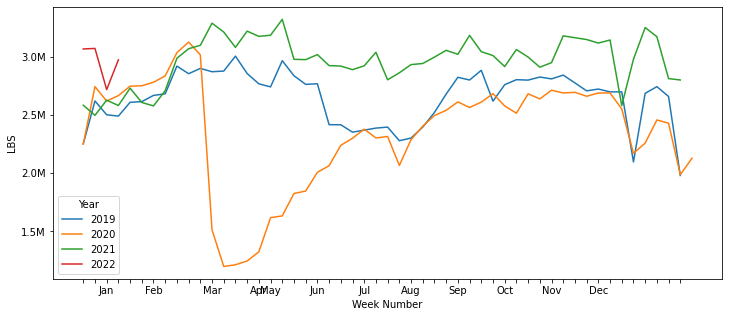

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.dates as mdates

df = output1.copy()
#print(df.info())

df['Week Number'] = df['Week Ending (Sat)'].dt.isocalendar().week
df['Year'] = df['Week Ending (Sat)'].dt.isocalendar().year

group = df.groupby([pd.Grouper(key='Week Ending (Sat)', freq='W'),'Distributor'])['LBS'].sum().reset_index()

group['Week Number'] = group['Week Ending (Sat)'].dt.isocalendar().week
group['Year'] = group['Week Ending (Sat)'].dt.isocalendar().year.astype('str')
#print(group['Week Number'])

fig, ax1 = plt.subplots(figsize=(12, 5))
sns.lineplot(x='Week Number', y='LBS', data=group, hue='Year', ax=ax1)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))

#ormatter = mdates.DateFormatter("%Y-%m-%d")

#ax1.xaxis.set_major_locator(mdates.MonthLocator())
#ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m"))

#ax2.xaxis.set_ticks(a) #set the ticks to be a
#ax2.xaxis.set_ticklabels(x) # change the ticks' names to x

ax1.set_xticks(range(1,53))
ax1.set_xticklabels(['','','Jan','',
                     '','','Feb','',
                     '','','','Mar',
                     '','','','Apr',
                     'May','','','',
                     'Jun','','','',
                     'Jul','','','',
                     'Aug','','','',
                     'Sep','','','',
                     'Oct','','','',
                     'Nov','','','',
                     'Dec','','','','','','',''])

plt.show()

In [37]:
group.tail()

,Week Ending (Sat),Distributor,LBS,Week Number,Year
156,2022-01-02,US Foods,2801861.09,52,2022
157,2022-01-09,US Foods,3068381.43,1,2022
158,2022-01-16,US Foods,3073082.66,2,2022
159,2022-01-23,US Foods,2719088.36,3,2022
160,2022-01-30,US Foods,2974804.93,4,2022


In [44]:
df = output1.copy()
#print(df.info())

df['Week Number'] = df['Week Ending (Sat)'].dt.isocalendar().week
#df['Year'] = df['Week Ending (Sat)'].dt.year
df['Year'] = df['Week Ending (Sat)'].dt.isocalendar().year
df

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,Calendar Week Year,Distributor,LBS,SMA_4,...,LBS_Lag_1,LBS_Lag_2,LBS_Lag_3,LBS_Lag_4,LBS_PRECOVID,Week Starting (Sun),Week Ending (Sat),COVID Week,Week Number,Year
0,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201901,US Foods,1694.6,1694.60,...,0.0,0.0,0.0,0.0,5027.19,2018-12-30,2019-01-05,0,1,2019
1,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201902,US Foods,2324.1,2009.35,...,1694.6,0.0,0.0,0.0,5027.19,2019-01-06,2019-01-12,0,2,2019
2,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201903,US Foods,3357.0,2458.57,...,2324.1,1694.6,0.0,0.0,5027.19,2019-01-13,2019-01-19,0,3,2019
3,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201904,US Foods,9396.0,4192.92,...,3357.0,2324.1,1694.6,0.0,5027.19,2019-01-20,2019-01-26,0,4,2019
4,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201905,US Foods,1737.0,4203.52,...,9396.0,3357.0,2324.1,1694.6,5027.19,2019-01-27,2019-02-02,0,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94985,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202152,US Foods,70.0,70.00,...,40.0,80.0,90.0,80.0,181.52,2021-12-26,2022-01-01,94,52,2021
94986,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202201,US Foods,65.0,63.75,...,70.0,40.0,80.0,90.0,181.52,2022-01-02,2022-01-08,95,1,2022
94987,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202202,US Foods,10.0,46.25,...,65.0,70.0,40.0,80.0,181.52,2022-01-09,2022-01-15,96,2,2022
94988,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202203,US Foods,10.0,38.75,...,10.0,65.0,70.0,40.0,181.52,2022-01-16,2022-01-22,97,3,2022


In [42]:
x = df.groupby(["Week Number", "Year"])["LBS"].sum()
df_wide = x.unstack()
print(df['Week Ending (Sat)'].max())
print(df_wide.head(60))

2022-01-29 00:00:00
Year              2019        2020        2021        2022
Week Number                                               
1            2252930.3  2251358.00  2584901.16  3068381.43
2            2621522.6  2744666.00  2498020.92  3073082.66
3            2502578.0  2620692.00  2628854.80  2719088.36
4            2491395.0  2667491.00  2582271.60  2974804.93
5            2609943.0  2748770.00  2731491.94         NaN
6            2615823.0  2751953.00  2608535.48         NaN
7            2669269.0  2782477.00  2579032.52         NaN
8            2682895.0  2836655.00  2710287.18         NaN
9            2921311.0  3036691.00  2988334.96         NaN
10           2855705.0  3127258.00  3070454.84         NaN
11           2901428.0  3017970.00  3099727.98         NaN
12           2872691.0  1513628.00  3289931.74         NaN
13           2878434.0  1199258.00  3213630.24         NaN
14           3006807.0  1213668.00  3082174.68         NaN
15           2857369.0  1246126.00  